<a href="https://colab.research.google.com/github/nicolasquant/Mercado_Financeiro/blob/main/CAPM_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


            s_adjclose   m_adjclose  s_returns  m_returns
Date                                                     
2010-02-28   72.667770  1104.489990   0.042696   0.028115
2010-03-31   73.290657  1169.430054   0.008535   0.057133
2010-04-30   73.719246  1186.689941   0.005831   0.014651
2010-05-31   71.948891  1089.410034  -0.024308  -0.085532
2010-06-30   70.926460  1030.709961  -0.014312  -0.055388
beta calculado a partir da regrssão linear 0.9493615670645714
retorno esperado da ação 0.15544659399764704


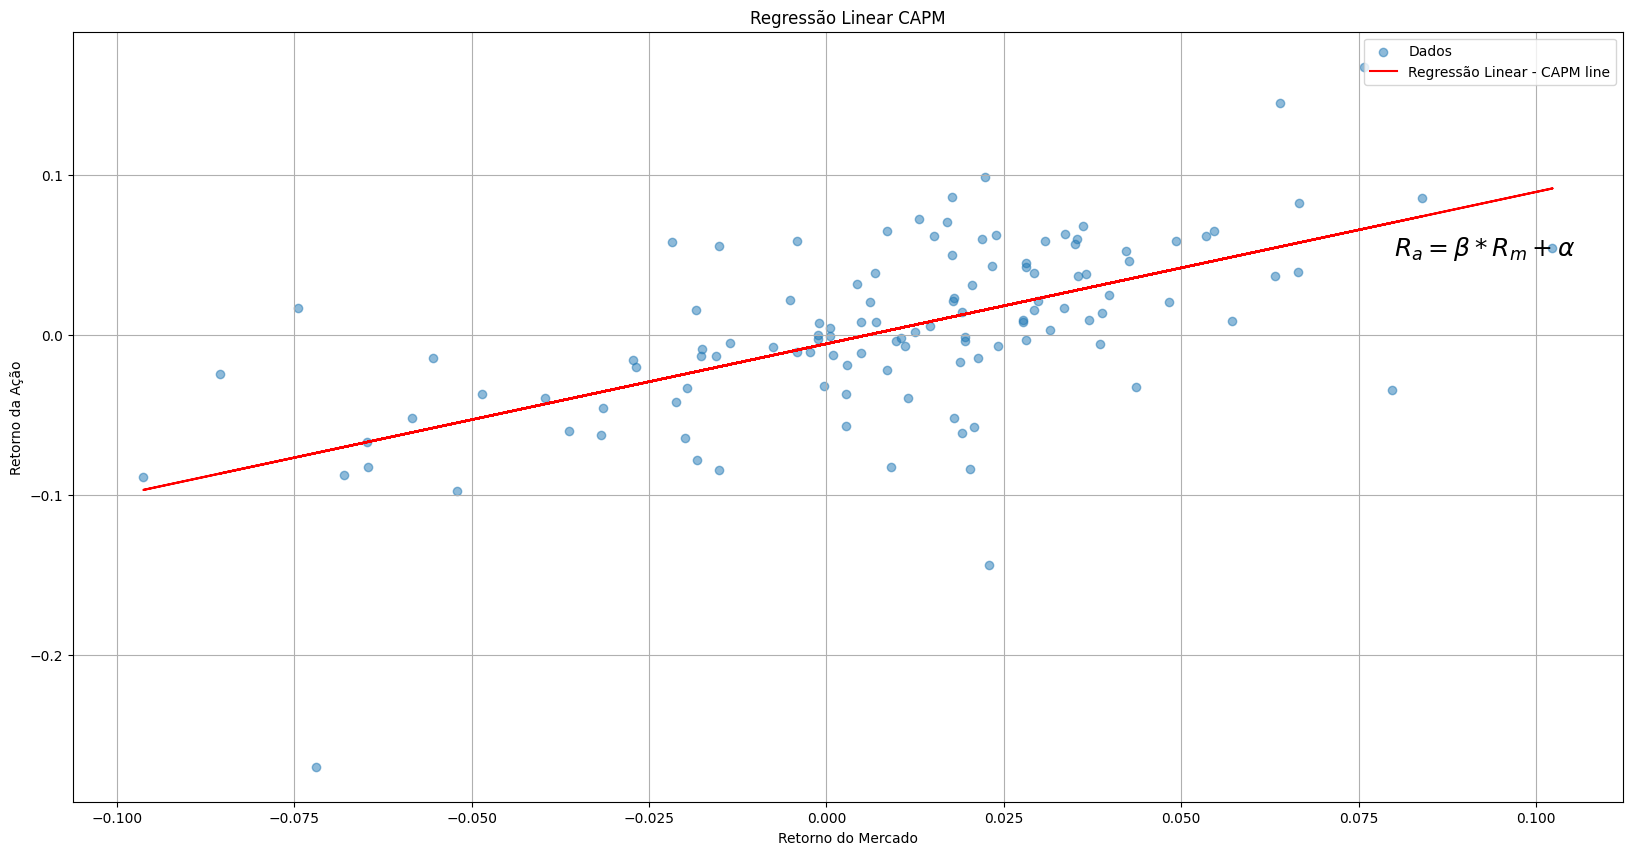

In [ ]:
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd

risk_free_rate = 0.05 # rf
months_in_year = 12 # vamos considerar retornos mensais e iremos calcular um retorno anual

class CAPM:
    def __init__(self, stock, start_date, end_date):
        self.data = None
        self.stocks = stocks
        self.start_date = start_date
        self.end_date = end_date

    def get_data(self):

        data = {}
        # Download the data for each stock
        for stock in self.stocks:
            data[stock] = yf.download(stock, start=self.start_date, end=self.end_date)['Adj Close']
        return pd.DataFrame(data)

    def initialize(self): # nessa função, estamos selecionando e printando os dados mensais (o valor de fechamento mensal da ação)
        stocks_data = self.get_data()
        # usaremos os retornos mensais ao inves dos retornos diários
        stocks_data = stocks_data.resample('ME').last()

        self.data = pd.DataFrame({'s_adjclose': stocks_data[self.stocks[0]],
                                 'm_adjclose': stocks_data[self.stocks[1]]})
        # stocks adjustment closing pricing e market adjustment closing price
        # vamos fazer o retorno mensal logaritmico
        self.data[['s_returns', 'm_returns']] = np.log(self.data[['s_adjclose', 'm_adjclose']] / self.data[['s_adjclose', 'm_adjclose']].shift(1)) # aqui, criamos um dataset de duas colunas onde a primeira possui o retorno das stocks e a segunda, do mercado
        #vamos revomer NAN values
        self.data = self.data[1:]
        print(self.data.head())

    def beta(self):
        covariance_matrix =  np.cov(self.data['s_returns'], self.data['m_returns'])
        beta = covariance_matrix[0, 1] / covariance_matrix[1, 1] # obs: beta é a covariancia das estocks em relação ao mercado / variancia do marcado
        # obs: a matriz de covariancia nos retornará:
        #[0,0]: variância da stock.
        #[1,1]: variância do mercado.
        #[0,1] e [1,0]: covariância entre stock e mercado.
        return beta

    def regression(self): # aqui, faremos a regressão da reta CAPM, que possui o beta como coeficiente angular
        beta, alpha = np.polyfit(self.data['m_returns'], self.data['s_returns'], deg=1) #np.polyfit faz uma regrssão linear a partir dos dados cedidos. deg=1 significa que estamos fazendo uma regressão linear de um polinomio de grau 1 (reta)
        print('beta calculado a partir da regrssão linear', beta)
        # nós calculamos beta anteriormente, mas esse beta obtido acima, nos é dado a partir da regrssão linear. o np.polyfit, nos retorna o coef angular e o linear, consecutivamente
        # depois de alpha e beta já calculados, vamos calcular o valor de retorno esperado (reta CAPM)
        expected_return = risk_free_rate + beta * (self.data['m_returns'].mean()* months_in_year) # FÓRMULA NO TABLET
        print('retorno esperado da ação', expected_return)
        self.plot_regression(alpha,beta) # vamos criar essa def abaixo

    def plot_regression(self, alpha, beta):
        fig, axis  = plt.subplots(1, figsize=(20, 10))
        axis.scatter(self.data['m_returns'], self.data['s_returns'], label='Dados', alpha=0.5)
        axis.plot(self.data['m_returns'], alpha + beta * self.data['m_returns'], color='red', label='Regressão Linear - CAPM line')
        plt.title('Regressão Linear CAPM')
        plt.xlabel('Retorno do Mercado')
        plt.ylabel('Retorno da Ação')
        plt.text(0.08, 0.05, r'$R_a = \beta * R_m + \alpha$', fontsize=18)
        plt.legend()
        plt.grid(True)
        plt.show()

if __name__ == "__main__":
    stocks = ['IBM', '^GSPC']
    start_date = '2010-01-01'
    end_date = '2020-01-01'
    capm = CAPM(stocks, start_date, end_date) # note que temos que iniciar a classe CAPM antes de chamar os argumentos dela
    data = capm.get_data()
    capm.initialize()
    capm.regression() # se nao rodarmos o initialize antes, o .regression dá erro pois definimos o self.data = None
    # print(capm.beta()) # note que nosso beta é quase 1, então nossa ação possui um comportamento semelhante ao do mercado
